# Speech Project
## Article : **SPEECH EMOTION RECOGNITION USING CAPSULE NETWORK**
### Student Name : Sobhan Asasi
### Student Number: 400206392

## Requirements

In [1]:
import torch
import torchvision
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

import warnings
warnings.filterwarnings('ignore')

Using cuda device


## Extract information of .wav files

In [2]:
ext_audio = '.wav'
emotions = { 'W': 1, 'F': 2, 'T': 3, 'N': 0 } # W = anger, F = happiness, T = sadness, N = neutral
root = '/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/'
# Iterate through all audio files
data = []
for _, _, files in os.walk(root):
    for file in files:
        if file.endswith(ext_audio):
            # Construct file identifiers
            identifiers = [file[0:2], file[2:5], file[5], file[6], os.path.join(root, file)]

            # Append identifier to data
            if file[5] in emotions.keys():
                data.append(identifiers)

# Create pandas dataframe
emo_df = pd.DataFrame(data, columns=['speaker_id', 'code', 'emotion', 'version', 'file'], dtype=np.float32)

# Map emotion labels to numeric values
emo_df['emotion'] = emo_df['emotion'].map(emotions).astype(np.float32)

In [3]:
N_total = len(emo_df)
print('The number of samples is : {}'.format(N_total))
N_neut = len(emo_df[emo_df['emotion'] == 0])
print('The number of angry samples is : {}({:.2f}%)'.format(N_neut, (N_neut/N_total)*100))
N_angry = len(emo_df[emo_df['emotion'] == 1])
print('The number of angry samples is : {}({:.2f}%)'.format(N_angry, (N_angry/N_total)*100))
N_happy = len(emo_df[emo_df['emotion'] == 2])
print('The number of happy samples is : {}({:.2f}%)'.format(N_happy, (N_happy/N_total)*100))
N_sad = len(emo_df[emo_df['emotion'] == 3])
print('The number of sad samples is : {}({:.2f}%)'.format(N_sad, (N_sad/N_total)*100))

The number of samples is : 339
The number of angry samples is : 79(23.30%)
The number of angry samples is : 127(37.46%)
The number of happy samples is : 71(20.94%)
The number of sad samples is : 62(18.29%)


In [4]:
N_test = int(0.2 * N_total)
N_train = N_total - N_test
print('The number of train samples is : {}'.format(N_train))
print('The number of test samples is : {}'.format(N_test))

N_test_neut = int(N_test*(N_neut/N_total))
print('The number of neutral samples in test dataset is : {}'.format(N_test_neut))
N_test_angry = int(N_test*((N_angry/N_total)))
print('The number of angry samples in test dataset is : {}'.format(N_test_angry))
N_test_happy = int(N_test*((N_happy/N_total)))
print('The number of happy samples in test dataset is : {}'.format(N_test_happy))
N_test_sad = int(N_test*((N_sad/N_total)))
print('The number of sad samples in test dataset is : {}'.format(N_test_sad))

The number of train samples is : 272
The number of test samples is : 67
The number of neutral samples in test dataset is : 15
The number of angry samples in test dataset is : 25
The number of happy samples in test dataset is : 14
The number of sad samples in test dataset is : 12


In [5]:
N_samples = [N_test_neut,N_test_angry,N_test_happy,N_test_sad]
train_data = pd.DataFrame({})
test_data = pd.DataFrame({})
for idx in range(4):
    df2 = emo_df[emo_df['emotion'] == idx]
    test_df = df2.sample(n=N_samples[idx])
    test_data = pd.concat([test_data,test_df])
    train_df = df2.drop(index=test_df.index)
    train_data = pd.concat([train_data,train_df])

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [6]:
train_data.head()

,speaker_id,code,emotion,version,file
0,8.0,b02,0.0,b,/kaggle/input/berlin-database-of-emotional-spe...
1,3.0,b01,0.0,b,/kaggle/input/berlin-database-of-emotional-spe...
2,12.0,a02,0.0,b,/kaggle/input/berlin-database-of-emotional-spe...
3,15.0,b10,0.0,b,/kaggle/input/berlin-database-of-emotional-spe...
4,13.0,b01,0.0,c,/kaggle/input/berlin-database-of-emotional-spe...


In [7]:
test_data.head()

,speaker_id,code,emotion,version,file
0,16.0,a02,0.0,b,/kaggle/input/berlin-database-of-emotional-spe...
1,9.0,a01,0.0,b,/kaggle/input/berlin-database-of-emotional-spe...
2,14.0,a07,0.0,a,/kaggle/input/berlin-database-of-emotional-spe...
3,8.0,a02,0.0,a,/kaggle/input/berlin-database-of-emotional-spe...
4,3.0,a05,0.0,d,/kaggle/input/berlin-database-of-emotional-spe...


## Create DataSet and DataLoader

In [8]:
class EmodbDataset(object):
    """
        Create a Dataset for Emodb. Each item is a tuple of the form:
        (waveform, sample_rate, emotion)
    """
    
    def __init__(self, dataframe):
        """
        Args:
            root (string): Directory containing the wav folder
        """
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_path = self.df.loc[idx, 'file']
        waveform, sample_rate = torchaudio.load(audio_path, normalize=True)
        if waveform.shape[1] > 32000:
            waveform = waveform[:, :32000]
        pad = 32000 - waveform.shape[1]
        r_pad = pad // 2
        l_pad = pad - r_pad
        waveform = torch.cat([torch.zeros((1,r_pad)), waveform, torch.zeros((1,l_pad))], dim=1)
        emotion = self.df.loc[idx, 'emotion']
        transform = torchaudio.transforms.MelSpectrogram(n_fft=1600, win_length=640, hop_length=161, n_mels=512)

        sample = {
            'waveform': waveform,
            'spec': transform(waveform),
            'sample_rate': sample_rate,
            'emotion': emotion
        }

        return sample


In [9]:
dataset_train = EmodbDataset(train_data)
dataset_test = EmodbDataset(test_data)

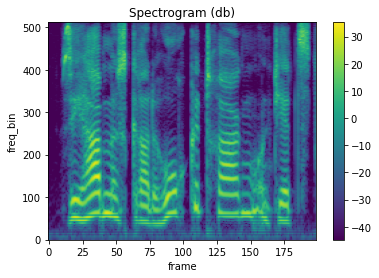

In [10]:
import librosa
def plot_spec(specgram, title=None, y_label='freq_bin'):
    fig, axs = plt.subplots(1,1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(y_label)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram),origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
sample = dataset_train[0]
sample['spec'].shape
plot_spec(sample['spec'][0])

# GRU Model

In [11]:
# Hyperparameters
input_size = 21
sequence_length = 7
hidden_size = 32
num_layers = 2
num_classes = 4
batch_size = 64


class BGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.GRU(
            input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.fc1 = nn.Linear(64, num_classes)
        self.prob = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.shape[0]*x.shape[1],x.shape[2],x.shape[3])
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        out = out.view(16,-1)
        out = self.fc1(out)
        out = self.prob(out)

        return out

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
inp = torch.randn((16,16,7,21))
model = BGRU(input_size, hidden_size, num_layers, num_classes)
out = model(inp)
print(out.shape)

torch.Size([16, 4])


# Capsule Network

In [13]:
def squash(inputs, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param inputs: vectors to be squashed
    :param axis: the axis to squash
    :return: a Tensor with same size as inputs
    """
    norm = torch.norm(inputs, p=2, dim=axis, keepdim=True)
    scale = norm**2 / (1 + norm**2) / (norm + 1e-8)
    return scale * inputs


class DenseCapsule(nn.Module):
    """
    The dense capsule layer. It is similar to Dense (FC) layer. Dense layer has `in_num` inputs, each is a scalar, the
    output of the neuron from the former layer, and it has `out_num` output neurons. DenseCapsule just expands the
    output of the neuron from scalar to vector. So its input size = [None, in_num_caps, in_dim_caps] and output size = \
    [None, out_num_caps, out_dim_caps]. For Dense Layer, in_dim_caps = out_dim_caps = 1.
    :param in_num_caps: number of cpasules inputted to this layer
    :param in_dim_caps: dimension of input capsules
    :param out_num_caps: number of capsules outputted from this layer
    :param out_dim_caps: dimension of output capsules
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, in_num_caps, in_dim_caps, out_num_caps, out_dim_caps, routings=3):
        super(DenseCapsule, self).__init__()
        self.in_num_caps = in_num_caps
        self.in_dim_caps = in_dim_caps
        self.out_num_caps = out_num_caps
        self.out_dim_caps = out_dim_caps
        self.routings = routings
        self.weight = nn.Parameter(0.01 * torch.randn(out_num_caps, in_num_caps, out_dim_caps, in_dim_caps))

    def forward(self, x):
        # x.size=[batch, in_num_caps, in_dim_caps]
        # expanded to    [batch, 1,            in_num_caps, in_dim_caps,  1]
        # weight.size   =[       out_num_caps, in_num_caps, out_dim_caps, in_dim_caps]
        # torch.matmul: [out_dim_caps, in_dim_caps] x [in_dim_caps, 1] -> [out_dim_caps, 1]
        # => x_hat.size =[batch, out_num_caps, in_num_caps, out_dim_caps]
        #print(self.weight.shape, x.shape)
        x_hat = torch.squeeze(torch.matmul(self.weight, x[:, None, :, :, None]), dim=-1).to(device)

        # In forward pass, `x_hat_detached` = `x_hat`;
        # In backward, no gradient can flow from `x_hat_detached` back to `x_hat`.
        x_hat_detached = x_hat.detach().to(device)

        # The prior for coupling coefficient, initialized as zeros.
        # b.size = [batch, out_num_caps, in_num_caps]
        b = Variable(torch.zeros(x.size(0), self.out_num_caps, self.in_num_caps)).to(device)

        assert self.routings > 0, 'The \'routings\' should be > 0.'
        for i in range(self.routings):
            # c.size = [batch, out_num_caps, in_num_caps]
            c = F.softmax(b, dim=1).to(device)

            # At last iteration, use `x_hat` to compute `outputs` in order to backpropagate gradient
            if i == self.routings - 1:
                # c.size expanded to [batch, out_num_caps, in_num_caps, 1           ]
                # x_hat.size     =   [batch, out_num_caps, in_num_caps, out_dim_caps]
                # => outputs.size=   [batch, out_num_caps, 1,           out_dim_caps]
                outputs = squash(torch.sum(c[:, :, :, None] * x_hat, dim=-2, keepdim=True))
                # outputs = squash(torch.matmul(c[:, :, None, :], x_hat))  # alternative way
            else:  # Otherwise, use `x_hat_detached` to update `b`. No gradients flow on this path.
                outputs = squash(torch.sum(c[:, :, :, None] * x_hat_detached, dim=-2, keepdim=True))
                # outputs = squash(torch.matmul(c[:, :, None, :], x_hat_detached))  # alternative way

                # outputs.size       =[batch, out_num_caps, 1,           out_dim_caps]
                # x_hat_detached.size=[batch, out_num_caps, in_num_caps, out_dim_caps]
                # => b.size          =[batch, out_num_caps, in_num_caps]
                b = b + torch.sum(outputs * x_hat_detached, dim=-1)

        return torch.squeeze(outputs, dim=-2)


class PrimaryCapsule(nn.Module):
    """
    Apply Conv2D with `out_channels` and then reshape to get capsules
    :param in_channels: input channels
    :param out_channels: output channels
    :param dim_caps: dimension of capsule
    :param kernel_size: kernel size
    :return: output tensor, size=[batch, num_caps, dim_caps]
    """
    def __init__(self, in_channels, out_channels, dim_caps, kernel_size, stride=1, padding=0):
        super(PrimaryCapsule, self).__init__()
        self.dim_caps = dim_caps
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        outputs = self.conv2d(x)
        outputs = outputs.view(x.size(0), -1, self.dim_caps)
        return squash(outputs)

In [14]:
class CapsuleNet(nn.Module):
    """
    A Capsule Network on MNIST.
    :param input_size: data size = [channels, width, height]
    :param classes: number of classes
    :param routings: number of routing iterations
    Shape:
        - Input: (batch, channels, width, height), optional (batch, classes) .
        - Output:((batch, classes), (batch, channels, width, height))
    """
    def __init__(self, out_num_caps,  out_dim_caps, w_size, routings):
        super(CapsuleNet, self).__init__()
        self.out_num_caps = out_num_caps
        self.out_dim_caps = out_dim_caps
        self.w_size = w_size
        self.routings = routings

        # Layer 1: Just a conventional Conv2D layer
        #self.conv1 = nn.Conv2d(input_size[0], 256, kernel_size=9, stride=1, padding=0)

        # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_caps, dim_caps]
        self.primarycaps = PrimaryCapsule(self.w_size, 256, 8, kernel_size=5, stride=2, padding=0)

        # Layer 3: Capsule layer. Routing algorithm works here.
        self.digitcaps = DenseCapsule(in_num_caps=576, in_dim_caps=8,
                                      out_num_caps=self.out_num_caps, out_dim_caps=self.out_dim_caps, routings=routings)
        
        self.linear = nn.Linear(in_features=64, out_features=4)
        self.prob = nn.Softmax(dim=1)

    def forward(self, x, y=None):
        #print(x.shape)
        x = self.primarycaps(x)
        #print(x.shape)
        x = self.digitcaps(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        x = self.prob(x)
        
        return x


# CNN-GRU-SeqCaps

In [15]:
# Hyperparameters
input_size = 21
sequence_length = 7
hidden_size = 32
num_layers = 2
num_classes = 4

class Emotion(nn.Module):
    def __init__(self,lam=0.6):
        super(Emotion, self).__init__()
        
        self.lam = lam
        
        self.layer1a = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(2,8), padding=(0,3), stride=2)
        self.layer1b = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(8,2), padding=(3,0), stride=2)
        self.relu = nn.ReLU() 
        self.pool = nn.MaxPool2d(kernel_size=(2,1))
        
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.MaxPool2d(kernel_size=(4,1))
        )
        
        self.caps_net = CapsuleNet(4, 16, 16, 3)
        self.gru = BGRU(input_size, hidden_size, num_layers, num_classes)
        
    def forward(self, x):
        
        out1a = self.layer1a(x)
        out1a = self.relu(out1a)
        out1b = self.layer1b(x)
        out1b = self.relu(out1b)
        
        out1 = torch.cat([out1a, out1b], dim=1)
        out1 = self.pool(out1)
        
        features = self.feature(out1)
        
        prob1 = self.caps_net(features)
        prob2 = self.gru(features)
        
        total_prob = self.lam*prob1 + (1 - self.lam)*prob2
        
        return total_prob

In [16]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, 
                                            batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, 
                                            batch_size=batch_size, 
                                           shuffle=True)
batch_sample = next(iter(train_loader))
print(batch_sample['spec'].shape)

torch.Size([16, 1, 512, 199])


In [41]:
model = Emotion()
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
sgd_opt = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
# sgd_opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

In [34]:
print(model)

Emotion(
  (layer1a): Conv2d(1, 8, kernel_size=(2, 8), stride=(2, 2), padding=(0, 3))
  (layer1b): Conv2d(1, 8, kernel_size=(8, 2), stride=(2, 2), padding=(3, 0))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (feature): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (caps_net): CapsuleNet(
    (primarycaps): PrimaryCapsule(
      (conv2d): Conv2d(16, 256, kernel_size=(5, 5), stride=(2, 2))
    )
    (digitcaps): DenseCapsule()
    (linear): Linear(in_features=64, out_features=4, bias=True)
    (prob): Softmax(dim=1)
  )
  (

In [35]:
def train_loop(dataloader, model, loss_fn, optimizer, results, device="cpu"):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for batch, sample in enumerate(dataloader):
        
        X = sample['spec'].to(device)
        y = sample['emotion'].to(device)
        y = y.type(torch.LongTensor)
        y = y.to(device)
        if y.shape[0] != batch_size : continue
        #print(X)
        #print(next(model.parameters()).is_cuda)
        # Compute prediction and loss
        pred = model(X)
        #print(pred.shape, y.shape)
        
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    results['train loss'].append(train_loss)
    results['train accuracy'].append(100*correct)
    print(f"Train Metrics for faces: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}")

def valid_loop(dataloader, model, loss_fn, results, device="cpu", mode="valid"):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    
    with torch.no_grad():
        for batch, sample in enumerate(dataloader):
            
            X = sample['spec'].to(device)
            y = sample['emotion'].to(device)
            y = y.type(torch.LongTensor)
            y = y.to(device)
            if y.shape[0] != batch_size : continue
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            predict_face_label = pred.argmax(1)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    
    test_loss /= num_batches
    correct /= size
    results['valid loss'].append(test_loss)
    results['valid accuracy'].append(100*correct)
    if mode == "valid":
        print(f"Validation Metrics for faces: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    else:
        print(f"Test Metrics for faces: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [36]:
def train_valid(train_loader, valid_loader, loss_fn, optimizer, results, model_name, model, epochs, device="cpu"):
    
    model.to(device)
    print(f"{model_name}\n-------------------------------")
    for t in range(1, epochs+1):
      results['epoch'].append(t+1)
      print(f"Epoch {t}\n-------------------------------")
      #scheduler.step(t)
      train_loop(train_loader, model, loss_fn, optimizer, results, device=device)
      valid_loop(valid_loader, model, loss_fn, results, device=device)
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(list(range(epochs)), results['train accuracy'])
    plt.plot(list(range(epochs)), results['valid accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.legend(['train accuracy', 'valid accuracy'])
    plt.subplot(122)
    plt.plot(list(range(epochs)), results['train loss'])
    plt.plot(list(range(epochs)), results['valid loss'])
    plt.title(f'{model_name} Loss')
    plt.legend(['train loss', 'valid loss'])
    
    print("Done!")
    

CNN-GRU-SeqCaps
-------------------------------
Epoch 1
-------------------------------
loss: 1.384665  [    0/  273]
Train Metrics for faces: 
 Accuracy: 57.1%, Avg loss: 1.251250
Validation Metrics for faces: 
 Accuracy: 66.7%, Avg loss: 1.020029
Epoch 2
-------------------------------
loss: 1.270198  [    0/  273]
Train Metrics for faces: 
 Accuracy: 67.4%, Avg loss: 1.174180
Validation Metrics for faces: 
 Accuracy: 63.6%, Avg loss: 0.970255
Epoch 3
-------------------------------
loss: 1.218635  [    0/  273]
Train Metrics for faces: 
 Accuracy: 73.3%, Avg loss: 1.116556
Validation Metrics for faces: 
 Accuracy: 65.2%, Avg loss: 0.943049
Epoch 4
-------------------------------
loss: 1.067490  [    0/  273]
Train Metrics for faces: 
 Accuracy: 73.6%, Avg loss: 1.075647
Validation Metrics for faces: 
 Accuracy: 66.7%, Avg loss: 0.915693
Epoch 5
-------------------------------
loss: 1.157347  [    0/  273]
Train Metrics for faces: 
 Accuracy: 73.6%, Avg loss: 1.041154
Validation Metr

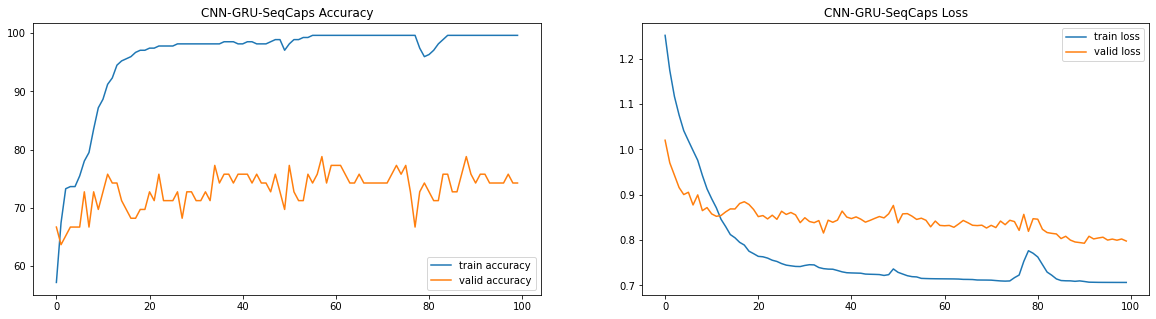

In [42]:
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, test_loader, loss_fn, sgd_opt, results, model_name="CNN-GRU-SeqCaps", model=model, epochs=num_epochs, device=device)

In [53]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, classes, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=2.8)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues")

In [54]:
def evaluate(dataloader, model, loss_fn, device="cpu"):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch, sample in enumerate(dataloader):
            
            X = sample['spec'].to(device)
            y = sample['emotion'].to(device)
            y = y.type(torch.LongTensor)
            y = y.to(device)
            if y.shape[0] != batch_size : continue
            y_true.extend(y.data.cpu().tolist())
            pred = model(X)
            y_pred.extend(pred.argmax(1).data.cpu().tolist())
            test_loss += loss_fn(pred, y).item()
            predict_face_label = pred.argmax(1)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Metrics for faces: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    
    cm_analysis(y_true, y_pred, labels=[0,1,2,3],classes=['Neutral','Angry','Happy','Sad'] , ymap=None, figsize=(17,17))

Test Metrics for faces: 
 Accuracy: 75.8%, Avg loss: 0.790994


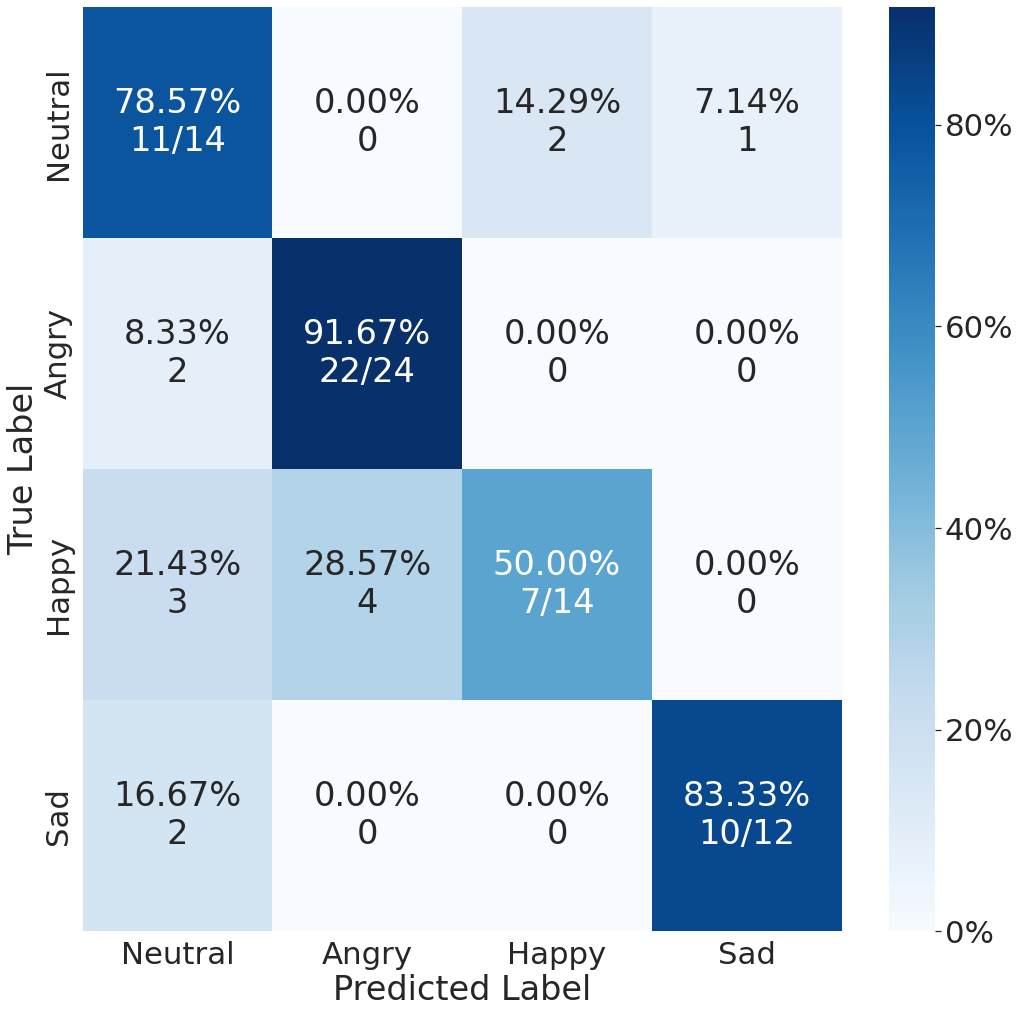

In [52]:
evaluate(test_loader, model, loss_fn, device=device)